## Stochastic diffusion model for climate data downscaling

This notebook implements diffusion models using the code from Jose González-Abad’s DataLab practice. It is an adaptation of the original work, using a stochastic diffusion model based on a UNet neural network to perform climate downscaling. The model learns to generate detailed climate patterns from low-resolution predictors through a diffusion process that adds and then removes noise, enabling the reconstruction of higher-resolution and more accurate climate data.

In [1]:
DATA_PATH = './data/input'
FIGURES_PATH = './figures'
MODELS_PATH = './models'
ASYM_PATH = './data/asym'

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from rpy2.robjects import r
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import xarray as xr
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.animation as animation
from IPython.display import HTML

import sys; sys.path.append('/home/canojm/deep4downscaling')
import deep4downscaling.c4r2d4d as c4r2d4d
import deep4downscaling.trans as trans
import deep4downscaling.deep.loss as loss
import deep4downscaling.deep.utils as utils
import deep4downscaling.deep.models as models
import deep4downscaling.deep.train as train
import deep4downscaling.deep.pred as pred
import deep4downscaling.metrics as metrics
import deep4downscaling.metrics_ccs

In [3]:
###--- PREPARING PREDICTORS ---###
loaded = r['load']('data/x.RData')
print("Objetos cargados:", list(loaded))
x = r[loaded[0]]
x = r['x']
grid = robjects.r['x']
predictor = c4r2d4d.c4r2d4d(grid)
#print(predictor)
predictor = predictor.squeeze("member")
#print(predictor)
predictor = predictor.drop_vars('member')
#print(predictor)
predictor['time'] = predictor.indexes['time'].normalize()
#print(predictor)

ordered_dims = ("lon", "lat", "time")
predictor_reordered = predictor.copy()

for var in predictor_reordered.data_vars:
    dims = predictor_reordered[var].dims
    if all(d in dims for d in ordered_dims):
        predictor[var] = predictor_reordered[var].transpose(*ordered_dims)

#print(predictor)

# (time, lat, lon)
predictor_final = predictor_reordered.copy()

for var in predictor_final.data_vars:
    predictor_final[var] = predictor_final[var].transpose("time", "lat", "lon")

#print(predictor_final)
predictor = xr.Dataset(
    data_vars={var: predictor_final[var] for var in predictor_final.data_vars},
    coords={
        "lon": predictor_final.coords["lon"],
        "lat": predictor_final.coords["lat"],
        "time": predictor_final.coords["time"]
    }
)

#print(predictor)
for var in predictor.data_vars:
    predictor[var].data = predictor[var].data.astype(np.float32)
print(predictor)

Objetos cargados: ['x']
<xarray.Dataset> Size: 109MB
Dimensions:  (lon: 24, lat: 24, time: 3653)
Coordinates:
  * lon      (lon) float64 192B -8.0 -6.0 -4.0 -2.0 0.0 ... 32.0 34.0 36.0 38.0
  * lat      (lat) float64 192B 36.0 38.0 40.0 42.0 44.0 ... 76.0 78.0 80.0 82.0
  * time     (time) datetime64[ns] 29kB 1996-01-01 1996-01-02 ... 2005-12-31
Data variables: (12/13)
    ta@500   (time, lat, lon) float32 8MB -14.35 -14.3 -13.61 ... -33.97 -33.9
    ta@700   (time, lat, lon) float32 8MB 0.9842 0.8668 1.557 ... -18.65 -18.61
    ta@850   (time, lat, lon) float32 8MB 8.884 9.058 9.497 ... -8.747 -8.496
    hus@500  (time, lat, lon) float32 8MB 0.0007277 0.0009141 ... 0.0002827
    hus@700  (time, lat, lon) float32 8MB 0.003512 0.00408 ... 0.0008152
    hus@850  (time, lat, lon) float32 8MB 0.005869 0.006584 ... 0.001976
    ...       ...
    ua@700   (time, lat, lon) float32 8MB 25.96 26.11 27.37 ... 9.703 9.289
    ua@850   (time, lat, lon) float32 8MB 17.3 18.71 21.77 ... 7.849 7.688 

In [4]:
###--- PREPARING THE PREDICTAND: SURFACE TEMPERATURE IN THIS CASE ---###
loaded = r['load']('data/ytas.RData')
print("Objetos cargados:", list(loaded))
x = r[loaded[0]]
x = r['y']
grid = robjects.r['y']
predictand = c4r2d4d.c4r2d4d(grid)
print(predictand)
predictand['tas'] = predictand['tas'].fillna(0)
print(predictand)

predictand= xr.Dataset(
    data_vars={var: predictand[var] for var in predictand.data_vars},
    coords={
        "lon": predictand.coords["lon"],
        "lat": predictand.coords["lat"],
        "time": predictand.coords["time"]
    }
)

print(predictand)
for var in predictand.data_vars:
    predictand[var].data = predictand[var].data.astype(np.float32)
print(predictand)

Objetos cargados: ['y']
<xarray.Dataset> Size: 275MB
Dimensions:  (time: 3653, lat: 97, lon: 97)
Coordinates:
  * lon      (lon) float64 776B -9.0 -8.5 -8.0 -7.5 -7.0 ... 37.5 38.0 38.5 39.0
  * lat      (lat) float64 776B 35.0 35.5 36.0 36.5 37.0 ... 81.5 82.0 82.5 83.0
  * time     (time) datetime64[ns] 29kB 1996-01-01 1996-01-02 ... 2005-12-31
Data variables:
    tas      (time, lat, lon) float64 275MB nan nan nan nan ... nan nan nan nan
<xarray.Dataset> Size: 275MB
Dimensions:  (time: 3653, lat: 97, lon: 97)
Coordinates:
  * lon      (lon) float64 776B -9.0 -8.5 -8.0 -7.5 -7.0 ... 37.5 38.0 38.5 39.0
  * lat      (lat) float64 776B 35.0 35.5 36.0 36.5 37.0 ... 81.5 82.0 82.5 83.0
  * time     (time) datetime64[ns] 29kB 1996-01-01 1996-01-02 ... 2005-12-31
Data variables:
    tas      (time, lat, lon) float64 275MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
<xarray.Dataset> Size: 275MB
Dimensions:  (lon: 97, lat: 97, time: 3653)
Coordinates:
  * lon      (lon) float64 776B -9.0 -8.5 -8.0 -

In [5]:
# ENSURING THE CORRECT STRUCTURE
print(predictor)
print(predictand)

<xarray.Dataset> Size: 109MB
Dimensions:  (lon: 24, lat: 24, time: 3653)
Coordinates:
  * lon      (lon) float64 192B -8.0 -6.0 -4.0 -2.0 0.0 ... 32.0 34.0 36.0 38.0
  * lat      (lat) float64 192B 36.0 38.0 40.0 42.0 44.0 ... 76.0 78.0 80.0 82.0
  * time     (time) datetime64[ns] 29kB 1996-01-01 1996-01-02 ... 2005-12-31
Data variables: (12/13)
    ta@500   (time, lat, lon) float32 8MB -14.35 -14.3 -13.61 ... -33.97 -33.9
    ta@700   (time, lat, lon) float32 8MB 0.9842 0.8668 1.557 ... -18.65 -18.61
    ta@850   (time, lat, lon) float32 8MB 8.884 9.058 9.497 ... -8.747 -8.496
    hus@500  (time, lat, lon) float32 8MB 0.0007277 0.0009141 ... 0.0002827
    hus@700  (time, lat, lon) float32 8MB 0.003512 0.00408 ... 0.0008152
    hus@850  (time, lat, lon) float32 8MB 0.005869 0.006584 ... 0.001976
    ...       ...
    ua@700   (time, lat, lon) float32 8MB 25.96 26.11 27.37 ... 9.703 9.289
    ua@850   (time, lat, lon) float32 8MB 17.3 18.71 21.77 ... 7.849 7.688 7.54
    va@500   (time,

In [6]:
predictor, predictand = trans.align_datasets(predictor, predictand, 'time') # align datasets by the time dimension

# define training-testing periods
# quick test setup!
years_train = ('1996', '2000')
years_test = ('2001', '2005')

# split the data into training and testing
x_train = predictor.sel(time=slice(*years_train))
x_test = predictor.sel(time=slice(*years_test))
y_train = predictand.sel(time=slice(*years_train))
y_test = predictand.sel(time=slice(*years_test))

# standardize the predictors
x_train_stand = trans.standardize(data_ref=x_train, data=x_train)
x_test_stand = trans.standardize(data_ref=x_train, data=x_test)

In [7]:
# convert predictors to numpy arrays
x_train_arr = trans.xarray_to_numpy(x_train_stand)  # [N, C, 24, 24]
x_test_arr = trans.xarray_to_numpy(x_test_stand)

# convert the predictand to numpy arrays
y_train_arr = y_train['tas'].values[:, None, :, :]  # add a channel dimension so the shape becomes [N,1, height, width]
y_test_arr = y_test['tas'].values[:, None, :, :]


In [8]:
print("x_train_arr shape:", x_train_arr.shape)
print("y_train_arr shape:", y_train_arr.shape)

x_train_arr shape: (1827, 13, 24, 24)
y_train_arr shape: (1827, 1, 97, 97)


In [9]:
# this code trims the spatial dimensions of the target arrays y_train_arr and y_test_arr from 97x97 down to 96x96. It keeps all samples and the single channel but crops one pixel off the height and width.
y_train_arr = y_train_arr[:, :, :96, :96]
y_test_arr = y_test_arr[:, :, :96, :96]

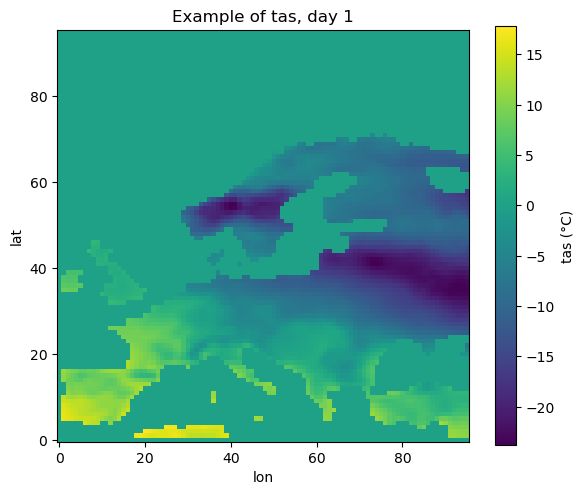

In [10]:
sample_tas = y_train_arr[0, 0, :, :]  # [96, 96]

plt.figure(figsize=(6, 5))
plt.imshow(sample_tas, origin='lower')
plt.title('Example of tas, day 1')
plt.colorbar(label='tas (°C)')
plt.xlabel('lon')
plt.ylabel('lat')
plt.tight_layout()
plt.show()

In [11]:
print("x_train_arr shape:", x_train_arr.shape)  # → [N, 13, 24, 24]
print("y_train_arr shape:", y_train_arr.shape)  # → [N, 1, 96, 96]
x_train_arr = x_train_arr[..., ::-1, :]
y_train_arr = y_train_arr[..., ::-1, :]

x_train_arr shape: (1827, 13, 24, 24)
y_train_arr shape: (1827, 1, 96, 96)


In [12]:
class GaussianDiffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        #TO DO: ¿y si el ruido no se añade de forma lineal?
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

    def q_sample(self, y_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(y_0)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1).to(y_0.device)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1).to(y_0.device)
        return sqrt_alphas_cumprod_t * y_0 + sqrt_one_minus_alphas_cumprod_t * noise

    @torch.no_grad()
    def sample(self, model, x_cond, shape, device):
        x = torch.randn(shape).to(device)
        for t in reversed(range(self.timesteps)): # de T a 0
            # prepara batch de tiempos
            t_batch = torch.full((shape[0],), t, device=device, dtype=torch.long)
            # predice el ruido con el modelo
            eps_pred = model(x, t_batch, x_cond)
            # calcula los coeficientes de la formula inversa
            beta_t = self.betas[t].to(device)
            alpha_t = self.alphas[t].to(device)
            alpha_bar_t = self.alphas_cumprod[t].to(device)
            # muestra ruido nuevo
            noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
            # ec. de muestreo inverso
            x = (
                1 / torch.sqrt(alpha_t) * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * eps_pred)
                + torch.sqrt(beta_t) * noise
            )
        return x

In [13]:
diffusion = GaussianDiffusion(timesteps=1000) # 1000 pasos

# Simular batch
y_batch = torch.randn(8, 1, 96, 96)
t_batch = torch.randint(0, 1000, (8,))

x_t = diffusion.q_sample(y_batch, t_batch)
print("x_t shape:", x_t.shape)  # → [8, 1, 96, 96]

x_t shape: torch.Size([8, 1, 96, 96])


In [14]:
class ClimateDataset(Dataset):
    def __init__(self, x_array, y_array):
        x_array = x_array[..., ::-1, :].copy()
        y_array = y_array[..., ::-1, :].copy()
        self.x = torch.from_numpy(x_array).float()
        self.y = torch.from_numpy(y_array).float()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Crear datasets
train_dataset = ClimateDataset(x_train_arr, y_train_arr)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [15]:
def upsample_x_cond(x_cond, target_size=(97, 97)):
    return F.interpolate(x_cond, size=target_size, mode="bilinear", align_corners=False)


class UNetDiffusionTas(nn.Module):
    def __init__(self, in_channels=14, embedding_dim=128):
        super().__init__()

        self.embedding_dim = embedding_dim

        # Embedding para el timestep
        self.time_mlp = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
        )

        # Encoder
        self.down1 = UnitConv(in_channels, 64, kernel_size=3, padding=1, batch_norm=True)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = UnitConv(64, 128, kernel_size=3, padding=1, batch_norm=True)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = UnitConv(128, 256, kernel_size=3, padding=1, batch_norm=True)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = UnitConv(256, 512, kernel_size=3, padding=1, batch_norm=True)

        # Decoder
        self.up1 = UpLayer(512, 256)
        self.up_conv1 = UnitConv(512, 256, kernel_size=3, padding=1, batch_norm=True)

        self.up2 = UpLayer(256, 128)
        self.up_conv2 = UnitConv(256, 128, kernel_size=3, padding=1, batch_norm=True)

        self.up3 = UpLayer(128, 64)
        self.up_conv3 = UnitConv(128, 64, kernel_size=3, padding=1, batch_norm=True)

        # Output
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x_t, t, x_cond):
        # 1. Reescalar los predictores
        x_cond_up = upsample_x_cond(x_cond, target_size=x_t.shape[-2:])

        # 2. Concatenar entrada
        x = torch.cat([x_t, x_cond_up], dim=1)  # [B, 14, 97, 97]

        # 3. Embedding del timestep
        t_emb = get_timestep_embedding(t, self.embedding_dim)  # [B, emb]
        t_emb = self.time_mlp(t_emb)[:, :, None, None]  # [B, 256, 1, 1]

        # 4. Encoder
        d1 = self.down1(x)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        b = self.bottleneck(p3 + t_emb)  # Suma broadcast con embedding

        # 5. Decoder con skip connections (y crop)
        u1 = self.up1(b)
        d3_crop = center_crop(d3, u1.shape[-2:])
        u1 = self.up_conv1(torch.cat([u1, d3_crop], dim=1))

        u2 = self.up2(u1)
        d2_crop = center_crop(d2, u2.shape[-2:])
        u2 = self.up_conv2(torch.cat([u2, d2_crop], dim=1))

        u3 = self.up3(u2)
        d1_crop = center_crop(d1, u3.shape[-2:])
        u3 = self.up_conv3(torch.cat([u3, d1_crop], dim=1))

        return self.out_conv(u3)  # [B, 1, 97, 97]


In [16]:
class UnitConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, batch_norm):
        super().__init__()
        if batch_norm:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                nn.ReLU()
            )

    def forward(self, x):
        return self.conv(x)

class UpLayer(nn.Module):
    def __init__(self, in_channels, out_channels, trans_conv=True):
        super().__init__()
        if trans_conv:
            self.layer_op = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        else:
            self.layer_op = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            )

    def forward(self, x):
        return self.layer_op(x)


In [17]:
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Devuelve un embedding sinusoidal para un batch de timesteps.
    """
    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = timesteps[:, None].float() * emb[None, :]  # (batch_size, half_dim)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb  # (batch_size, embedding_dim)

In [18]:
def center_crop(tensor, target_size):
    _, _, h, w = tensor.shape
    th, tw = target_size
    i = (h - th) // 2
    j = (w - tw) // 2
    return tensor[:, :, i:i+th, j:j+tw]


In [19]:
# Instanciar modelo y difusión
model = UNetDiffusionTas()
diffusion = GaussianDiffusion(timesteps=1000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 20  # o más

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Samplear timestep t y ruido ε
        t = torch.randint(0, diffusion.timesteps, (x_batch.size(0),), device=device)
        noise = torch.randn_like(y_batch)

        # x_t = sqrt(alpha_cumprod_t)*y + sqrt(1-alpha_cumprod_t)*ε
        x_t = diffusion.q_sample(y_batch, t, noise=noise)

        # Predicción del ruido
        noise_pred = model(x_t, t, x_batch)

        # MSE entre ruido real y ruido predicho
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")

Epoch 1 Loss: 49.8110
Epoch 2 Loss: 23.2436
Epoch 3 Loss: 17.8522
Epoch 4 Loss: 14.9319
Epoch 5 Loss: 12.2424
Epoch 6 Loss: 11.2383
Epoch 7 Loss: 10.2251
Epoch 8 Loss: 9.4587
Epoch 9 Loss: 8.8110
Epoch 10 Loss: 8.1838
Epoch 11 Loss: 8.0012
Epoch 12 Loss: 7.8536
Epoch 13 Loss: 8.5055
Epoch 14 Loss: 8.0434
Epoch 15 Loss: 7.4068
Epoch 16 Loss: 7.5019
Epoch 17 Loss: 7.0218
Epoch 18 Loss: 6.6345
Epoch 19 Loss: 7.6557
Epoch 20 Loss: 6.6055


In [20]:
@torch.no_grad()
def sample(self, model, x_cond, shape, device):
    """
    Genera una muestra desde ruido puro x_T condicionado a x_cond.
    - model: modelo UNet condicional entrenado
    - x_cond: predictores climáticos [B, 13, 24, 24]
    - shape: (B, 1, H, W) tamaño de la salida
    """
    x = torch.randn(shape).to(device)

    for t in reversed(range(self.timesteps)):
        t_batch = torch.full((shape[0],), t, device=device, dtype=torch.long)
        eps_pred = model(x, t_batch, x_cond)

        beta_t = self.betas[t].to(device)
        alpha_t = self.alphas[t].to(device)
        alpha_bar_t = self.alphas_cumprod[t].to(device)

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (
            1 / torch.sqrt(alpha_t) * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * eps_pred)
            + torch.sqrt(beta_t) * noise
        )

    return x  # [B, 1, H, W]


torch.Size([4, 1, 96, 96])


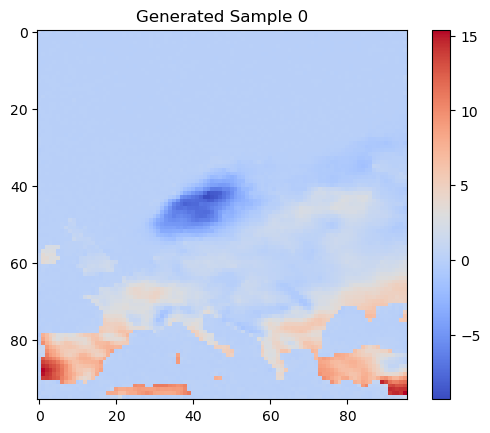

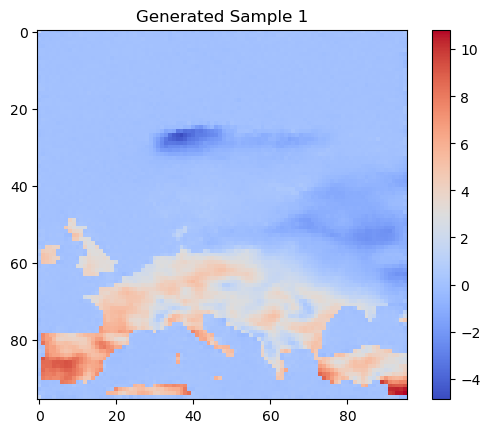

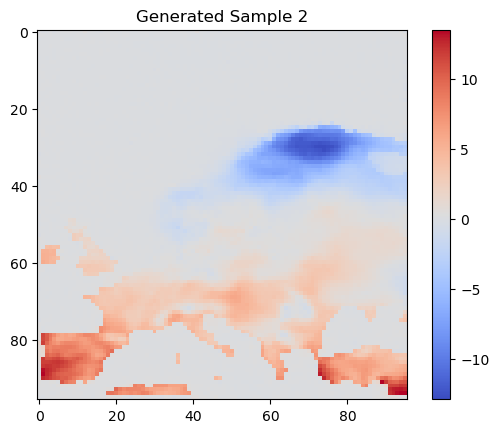

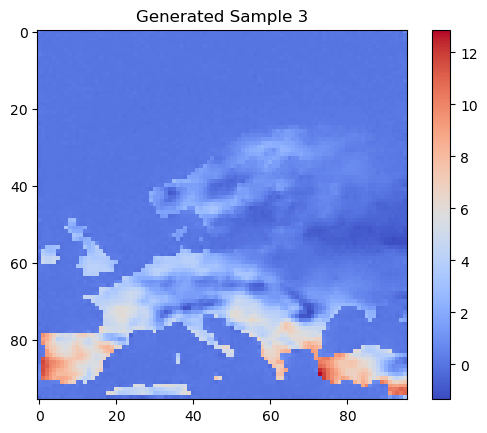

In [21]:
x_cond_test = torch.from_numpy(x_test_arr[:4]).float().to(device)  # 4 muestras
model.eval()
samples = diffusion.sample(model, x_cond_test, shape=(4, 1, 96, 96), device=device)
print(samples.shape)  # → torch.Size([4, 1, 96, 96])
import matplotlib.pyplot as plt

for i in range(4):
    plt.imshow(samples[i, 0].detach().cpu().numpy()[::-1], cmap="coolwarm")
    plt.title(f"Generated Sample {i}")
    plt.colorbar()
    plt.show()

In [22]:
fig, ax = plt.subplots(figsize=(6,5))

imgs = [samples[i, 0].detach().cpu().numpy() for i in range(4)]
imgs_norm = [(img - img.min()) / (img.max() - img.min()) for img in imgs]

im = ax.imshow(imgs_norm[0][::-1], cmap='coolwarm')
ax.set_title("Generated Sample 0")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(imgs_norm[frame][::-1])
    ax.set_title(f"Generated Sample {frame}")
    return [im]

ani = animation.FuncAnimation(fig, update, frames=4, interval=1000, blit=True)
plt.close()

HTML(ani.to_jshtml())

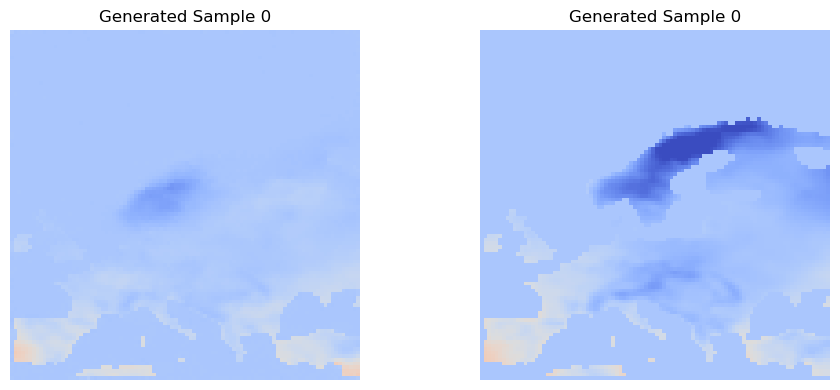

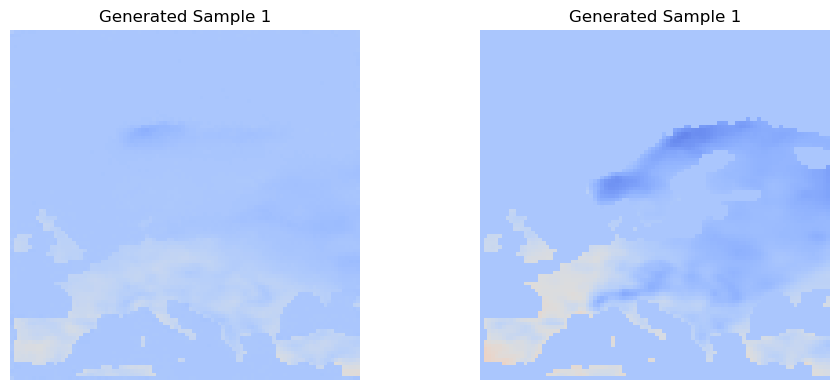

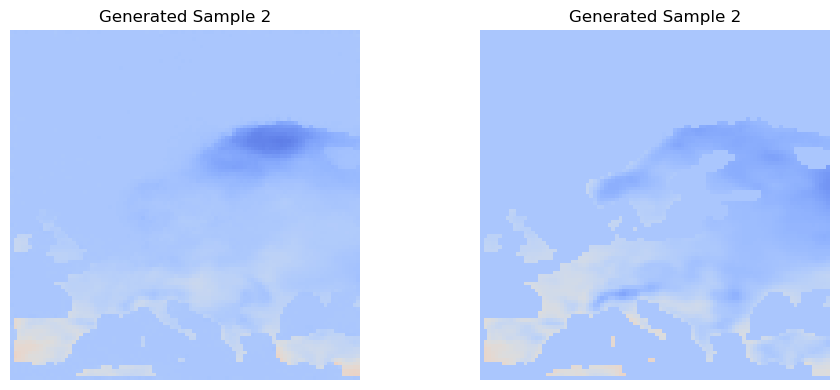

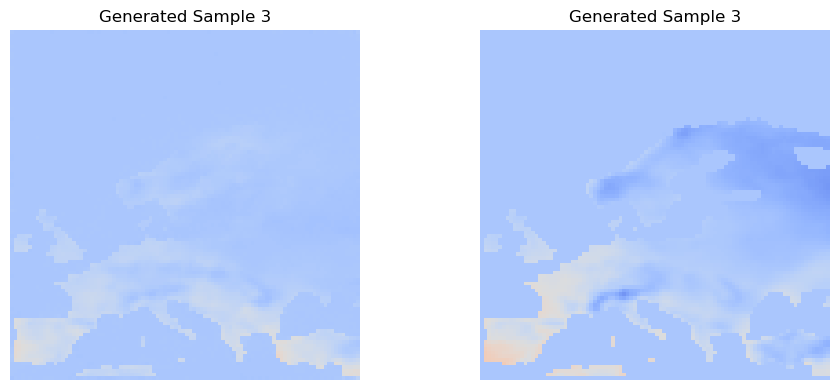

In [23]:
y_test_vis = y_test_arr[:4, :, :96, :96]  # aseguramos que coincida con shape [4, 1, 96, 96]
import matplotlib.pyplot as plt

for i in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    # Predicción generada
    axs[0].imshow(samples[i, 0].cpu().numpy()[::-1], cmap="coolwarm", vmin=-20, vmax=40)
    axs[0].set_title(f"Generated Sample {i}")
    axs[0].axis("off")
    # Observación real
    axs[1].imshow(y_test_vis[i, 0][::-1], cmap="coolwarm", vmin=-20, vmax=40)
    axs[1].set_title(f"Generated Sample {i}")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

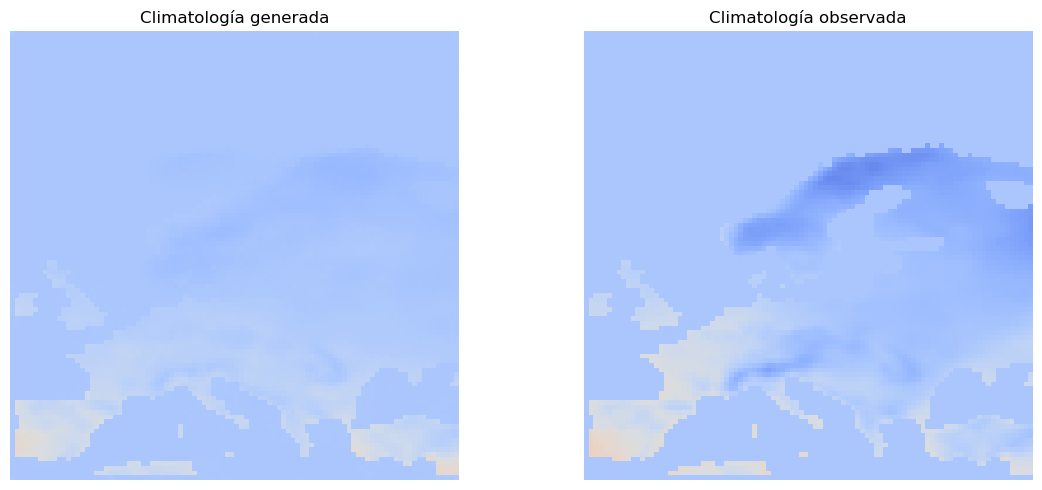

In [24]:
# Climatología de las muestras generadas
gen_clim = samples[:, 0].mean(dim=0).cpu().numpy()  # [96, 96]

# Climatología de las observaciones reales
obs_clim = y_test_vis[:, 0].mean(axis=0)  # [96, 96]

# Visualización
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(gen_clim[::-1], cmap="coolwarm", vmin=-20, vmax=40)
axs[0].set_title("Climatología generada")
axs[0].axis("off")

axs[1].imshow(obs_clim[::-1], cmap="coolwarm", vmin=-20, vmax=40)
axs[1].set_title("Climatología observada")
axs[1].axis("off")

plt.tight_layout()
plt.show()

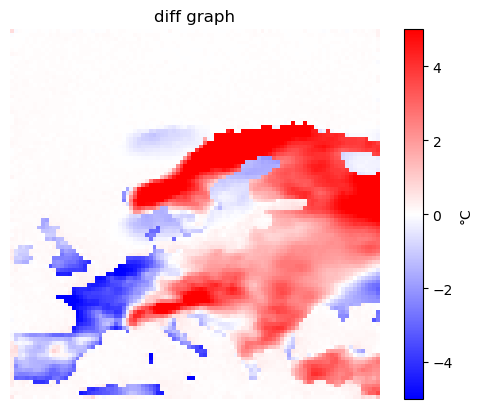

In [25]:
diff = gen_clim - obs_clim
plt.imshow(diff[::-1], cmap="bwr", vmin=-5, vmax=5)
plt.title("diff graph")
plt.colorbar(label="°C")
plt.axis("off")
plt.show()